# 模型选择、欠拟合和过拟合

通过多项式拟合来交互地探索这些概念

In [4]:
import sys
sys.path.append('..')

In [5]:
from d2l import mindspore as d2l
from mindspore import nn
import numpy as np
import math


[WARNING] CORE(200193,ffffb2765640,python):2025-12-14-21:48:57.880.099 [mindspore/core/utils/ms_context.cc:533] GetJitLevel] Set jit level to O2 for rank table startup method.
/usr/local/python3.10.14/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/python3.10.14/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/usr/local/python3.10.14/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/python3.10.14/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'n

使用以下三阶多项式来生成训练和测试数据的标签：
$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2)$$

In [6]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

看一下前2个样本

In [7]:
true_w, features, poly_features, labels = [x.astype(np.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(array([[-2.4983144 ],
        [ 0.91317445]], dtype=float32),
 array([[ 1.00000000e+00, -2.49831438e+00,  3.12078714e+00,
         -2.59890223e+00,  1.62321866e+00, -8.11062098e-01,
          3.37714672e-01, -1.20531052e-01,  3.76405567e-02,
         -1.04486598e-02,  2.61040358e-03, -5.92873490e-04,
          1.23432037e-04, -2.37209242e-05,  4.23302299e-06,
         -7.05028128e-07,  1.10086361e-07, -1.61782552e-08,
          2.24546470e-09, -2.95256652e-10],
        [ 1.00000000e+00,  9.13174450e-01,  4.16943818e-01,
          1.26914144e-01,  2.89736893e-02,  5.29160677e-03,
          8.05360032e-04,  1.05062034e-04,  1.19924962e-05,
          1.21680455e-06,  1.11115490e-07,  9.22434840e-09,
          7.01953273e-10,  4.93081374e-11,  3.21620963e-12,
          1.95797358e-13,  1.11748218e-14,  6.00268374e-16,
          3.04527634e-17,  1.46361513e-18]], dtype=float32),
 array([-23.281649 ,   5.4805365], dtype=float32))

实现一个函数来评估模型在给定数据集上的损失

In [8]:
def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上模型的损失。"""
    metric = d2l.Accumulator(2)
    for X, y in data_iter.create_tuple_iterator():
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum().asnumpy(), l.size)
    return metric[0] / metric[1]

定义训练函数

In [9]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.SequentialCell([nn.Dense(input_shape, 1, has_bias=False)])
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    optim = nn.SGD(net.trainable_params(), learning_rate=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, optim)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.asnumpy())

三阶多项式函数拟合(正态)

weight: [[ 4.525204   1.0432956 -3.219613   5.526337 ]]


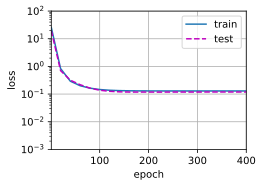

In [10]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

线性函数拟合(欠拟合)

weight: [[2.5416272 4.9677815]]


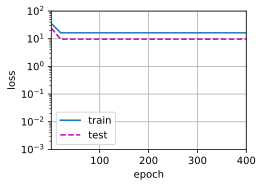

In [11]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

高阶多项式函数拟合(过拟合)

weight: [[ 4.4532      1.239359   -2.8776069   4.657332   -0.74880934  1.9726919
  -0.22239473  0.38616163 -0.08403326 -0.00729548  0.19463761 -0.15791772
  -0.00864829 -0.2022902  -0.07627523  0.01220069  0.06819646  0.12408196
  -0.17512448 -0.12373125]]


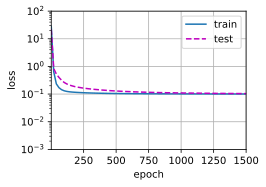

In [12]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)